## Inversion for a coupled acoustic-gravity system

Before running `pip install tinyda ray' 

### Problem setup

Let $\varphi$ be the potential for the flow velocity, it is solution to 
\begin{align}\label{eq:forwardmodel}
    \frac{\partial^2 \varphi}{\partial t^2}
    - c^2 \Delta \varphi 
    + g \frac{\partial \varphi}{\partial z}
    = 0,  \quad \text{ in } \Omega,
    \\
    \frac{\partial^2 \varphi}{\partial t^2}
    + g \frac{\partial \varphi}{\partial z} 
    = 0, \quad \text{ on } \Gamma_s,
    \\
    \nabla \varphi \cdot {\bf n}
    = u_b, \quad \text{ on } \Gamma_b,
\end{align}
where $c$ is the (constant) sound speed, $g$ is the gravity acceleration, ${\bf n}$ is the outwards unit vector normal to the seabed $\Gamma_b$ and $u_b$ is the seabed velocity.
The fluid displacement $u$ is related to the potential by $u = \nabla \varphi$.

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, norm, rv_continuous, wasserstein_distance
from scipy.spatial import distance_matrix

import tinyDA as tda
import umbridge
from FyeldGenerator import generate_field

In [49]:
np.random.seed(111)

### Initialising UM-Bridge
Before running the following cell, the model Docker image must be started from a system terminal using

`docker run -it -p 4242:4242 acousticgravity`

The Dockerfile can be found in the acousticgracity branch on UM-Bridge benchmarks. If not just running on a local machine replace `localhost` with the server.

In [51]:
# connect to the UM-Bridge model.
umbridge_model = umbridge.HTTPModel('http://localhost:4242', "forward")

# wrap the UM-Bridge model in the tinyDA UM-Bridge interface.
my_model = tda.UmBridgeModel(umbridge_model)

### Test model

Text(0.5, 0, 'x (adim unit)')

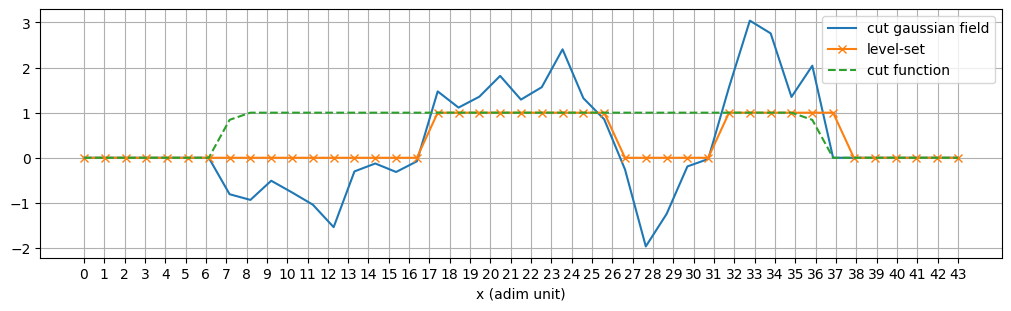

In [32]:
## Generate one input: level-set of a (cut) Gaussian field

############ Gaussian field
def smooth_cut(x, x0, width, k):
    step1 = 1/(1+np.exp( -k * ( x - (x0-width/2) ))) 
    step2 = 1/(1+np.exp( -k * ( x - (x0+width/2) ))) 
    return step1 - step2 

# Helper that generates power-law power spectrum
def Pkgen(n):
    def Pk(k):
        return np.power(k, -n)
    return Pk

# Draw samples from a normal distribution
def distrib(shape):
    a = np.random.normal(loc=0, scale=1, size=shape)
    b = np.random.normal(loc=0, scale=1, size=shape)
    return a + 1j * b

shape = (43, 1)
field = generate_field(distrib, Pkgen(2), shape)
field = field.flatten()
########################################################
# get the number of inputs and outputs.
nx_test = umbridge_model.get_input_sizes()[0] #the input is the value of f(x) at each grid point
x = np.linspace(0,43,nx_test)
cut = smooth_cut(x, 21.5, 43*(1-14/43), 10)
field_cut = np.multiply(field, cut)
eps = 1e-6
level_set = np.where(field_cut>eps,1,0)

#########################################################
fig, ax = plt.subplots(figsize=(10,3),layout="constrained")

ax.plot(x,field_cut, label='cut gaussian field')
ax.plot(x,level_set, 'x-', label='level-set')
ax.plot(x, cut, '--', label='cut function')
ax.set_xticks([i for i in range(44)])
ax.grid()
ax.legend()
ax.set_xlabel('x (adim unit)')

In [6]:
result = my_model(level_set)
# get the number of inputs and outputs.
nx = umbridge_model.get_input_sizes()[0] #the input is the value of f(x) at each grid point
ny = umbridge_model.get_output_sizes()[0] #the outout is a time series of the pressure

Text(0, 0.5, 'p (adim)')

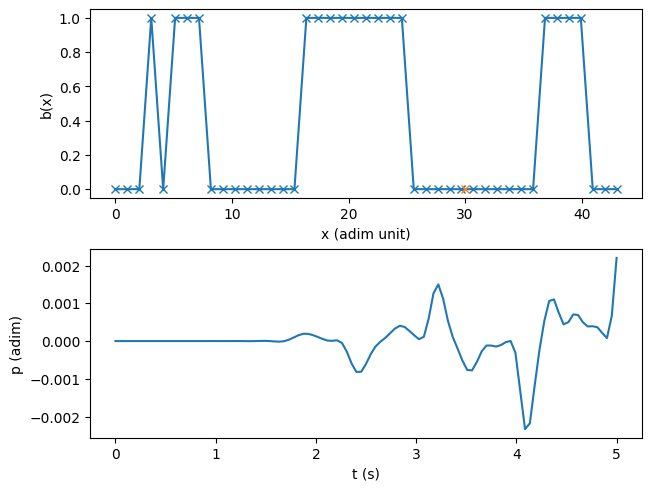

In [7]:
fig, ax = plt.subplots(2,1, layout="constrained")
x = np.linspace(0,43,nx)
ax[0].plot(x,level_set, 'x-')
ax[0].plot(30,0, marker='x')
ax[0].set_xlabel('x (adim unit)')
ax[0].set_ylabel('b(x)')

time = np.linspace(0,5,ny)
ax[1].plot(time, result)
ax[1].set_xlabel('t (s)')
ax[1].set_ylabel('p (adim)')


### Problem setup

In [52]:
# get the number of inputs and outputs.
nx = umbridge_model.get_input_sizes()[0] #the input is the value of f(x) at each grid point
ny = umbridge_model.get_output_sizes()[0] #the outout is a time series of the pressure

In [53]:
class LevelSet(rv_continuous):
    def __init__(self, power_law, size, eps, decay_rate):
        self.power_law = power_law
        self.size = size
        self.eps = eps 
        self.decay_rate = decay_rate
  
    ############ Gaussian field
    def smooth_cut(self, x, x0, width, k):
        step1 = 1/(1+np.exp( -k * ( x - (x0-width/2) ))) 
        step2 = 1/(1+np.exp( -k * ( x - (x0+width/2) ))) 
        return step1 - step2 

    # Draw samples from a normal distribution
    def distrib(self, output_shape):
        a = np.random.normal(loc=0, scale=1, size=output_shape)
        b = np.random.normal(loc=0, scale=1, size=output_shape)
        return a + 1j * b
    
    def generate_sample(self):
        output_shape = (self.size,1)
        field = generate_field(self.distrib, self.power_law, output_shape)
        field = field.flatten()

        x = np.linspace(0,self.size,self.size)
        # domain: take 6 units at each end to avoid reflexions 
        print(1-12/self.size)
        cut = self.smooth_cut(x, self.size/2., self.size*(1-14/self.size), self.decay_rate)
        field_cut = np.multiply(field, cut)
        
        eps = 1e-6
        level_set = np.where(field_cut>eps,1,0)
        return level_set

    def rvs(self, n_samples=1):
        x = np.array([self.generate_sample() for _ in range(n_samples)])
        if n_samples == 1:
            return x.flatten()
        else:
            return x
                
    def logpdf(self,x):
        y = self.generate_sample()
        return - wasserstein_distance(x,y)

    # 
    # Helper that generates power-law power spectrum
    # def Pkgen(n):
    #     def Pk(k):
    #         return np.power(k, -n)
    #     return Pk

## Test the class
# def Pkgen(n):
#     def Pk(k):
#         return np.power(k, -n)
#     return Pk

# my_prior = LevelSet(Pkgen(2),nx,1e-6,10)
# x=my_prior.rvs(nx)
# my_prior.logpdf(x)

0.7209302325581395


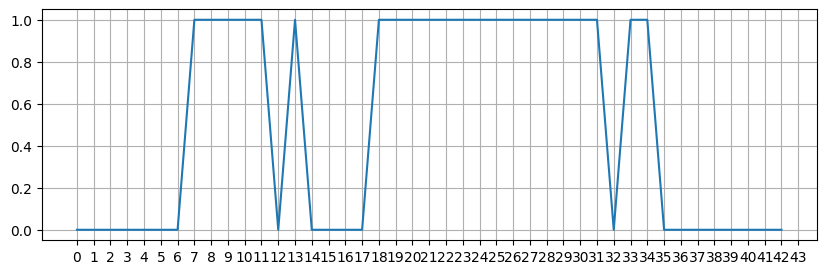

In [38]:
# # set the prior mean and covariance.
# mean_prior = 0.5 * np.ones(nx)  # zero corresponds to a fault at the center of the domain
# cov_prior = 0.125**2*np.eye(nx)    # The bulk of values will be in the interval [0,1]

# # initialise the prior distribution and likelihood.
# my_prior = multivariate_normal(mean_prior, cov_prior)

# Helper that generates power-law power spectrum
def Pkgen(n):
    def Pk(k):
        return np.power(k, -n)
    return Pk

my_prior = LevelSet(Pkgen(2),nx,1e-6,10)


fig,ax=plt.subplots(figsize=(10,3))
ax.set_xticks([i for i in range(44)])
ax.grid()

ax.plot(my_prior.rvs(1))


In [55]:
# generate synthetic data for input 0.5
# Input is a 15km wide fault centered around x
# Domain size is 150km
exact = np.zeros(nx)
#exact[int(nx/2 - 6):int(nx/2 + 5)]=1
exact[20:25]=1
d_true = my_model(exact)

# add some noise to the model output
sigma_noise = 0.5
d = d_true + np.random.normal(loc=0, scale=sigma_noise, size=ny)


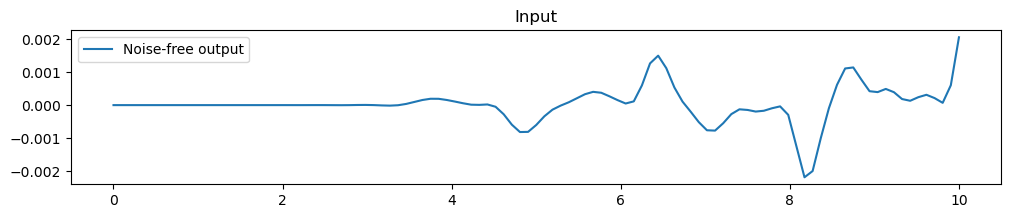

In [56]:
fig, ax = plt.subplots(figsize=(12,2))
ax.set_title('Input')
x=np.linspace(0,nx, nx)
t=np.linspace(0,10, ny)
#ax.plot(x,exact, label='Noise-free input')
ax.plot(t,d_true, label='Noise-free output')
ax.legend()

We plot only model output as the input is a simple 1D location so far

[0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 0 0 0]


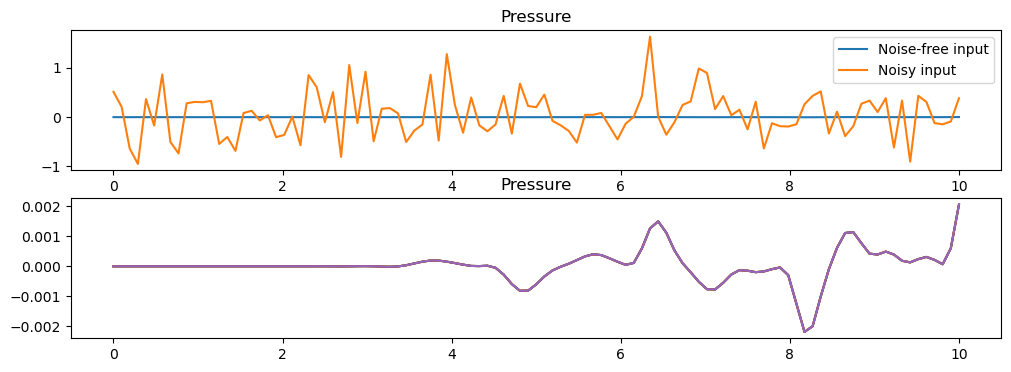

In [ ]:
# plot the model output
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,4))

# plot the time series of pressure
t = np.linspace(0,10,ny)
ax[0].set_title('Pressure')
ax[0].plot(t,d_true, label='Noise-free input')
ax[0].plot(t,d, label='Noisy input')
ax[0].legend()

ax[1].set_title('Pressure')
samples = []
inputs=[]
# Plot 10 random samples
for x in range(5):
    log = my_prior.rvs()
    d_sample = my_model(log)
    print(log)
    ax[1].plot(t, d_sample, label='samples')
    samples.append(d_sample)
    inputs.append(log)
plt.show()

Set up log-likelihood

#### TODO: Replace likelihood with and/or compare with Wasserstein distance

The "naive" choice seems to be causing some problems here. Juliette what would a reasonable distance be?

In [21]:
class wasserstein_loglike():
    def __init__(self, ground_truth):
        self.ground_truth = ground_truth
    
    def loglike(self,x):
        return - 100*wasserstein_distance(x,self.ground_truth)

In [22]:
# # set the covariance of the likelihood.
# sigma = 0.125
# cov_likelihood = sigma**2*np.eye(d.shape[0])
# my_loglike = tda.GaussianLogLike(d, cov_likelihood)
my_loglike = wasserstein_loglike(d_true)

# initialise the Posterior
my_posterior = tda.Posterior(my_prior, my_loglike, my_model)

In [23]:
for d_sample in samples:
    print(my_loglike.loglike(d_sample))

-0.5762827607470521
-0.5730257563930685
-0.14893983682976952
-0.12561768620645625
-0.5774112149844262


[0 0 0 0 0 0 0 1 1 1 1 0 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 0]
[0 0 0 0 0 0 0 1 1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0
 0 0 0 0 0 0]
[0 0 0 0 0 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0
 0 0 0 0 0 0]
[0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]


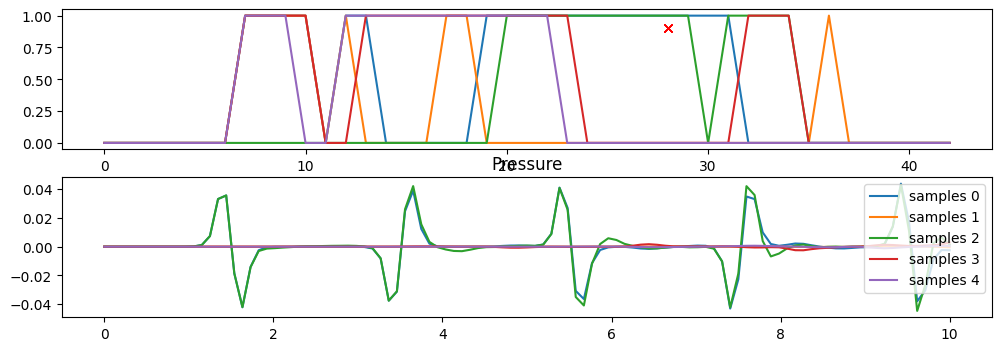

In [45]:
# plot the model output
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,4))

# plot the time series of pressure
# t = np.linspace(0,5,ny)
# ax[0].set_title('Pressure')
# ax[0].plot(t,d_true, label='Noise-free input')
# #ax[0].plot(t,d, label='Noisy input')
# ax[0].legend()

ax[1].set_title('Pressure')
# Plot 10 random samples
for i in range(5):
    #log = my_prior.rvs()
    #d_sample = my_model(log)
    log = inputs[i]
    print(log)
    ax[0].plot(log)
    ax[0].plot(28,0.9, 'x', color='red')
    ax[1].plot(t, samples[i], label=f'samples {i}')
    #samples.append(d_sample)
ax[1].legend()
plt.show()

### Set up the proposal

In [61]:
# # preconditioned Crank-Nicolson
# pcn_scaling = 0.1
# pcn_adaptive = True
# my_proposal = tda.CrankNicolson(scaling=pcn_scaling, adaptive=pcn_adaptive)

# # random walk Metropolis
rwmh_cov = np.eye(nx)
rmwh_scaling = 0.1
rwmh_adaptive = False
my_proposal = tda.GaussianRandomWalk(C=rwmh_cov, scaling=rmwh_scaling, adaptive=rwmh_adaptive)

### Sample

In [ ]:
# For testing purposes, iteration number is small for the given problem; Choose a larger number for real applications.
my_chains = tda.sample(my_posterior, my_proposal, iterations=10000, n_chains=2, force_sequential=True)

### Get some diagnostics

In [14]:
import arviz as az

In [ ]:
# convert the tinyDA chains to an ArViz InferenceData object.
idata = tda.to_inference_data(my_chains, burnin=100)

In [ ]:
# display posterior summary statistics.
az.summary(idata)

In [ ]:
# plot posterior kernel densities and traces.
az.plot_trace(idata, figsize=(18, 18))
plt.show()

In [18]:
# extract the parameters from the chains.
parameters = [link.parameters for link in my_chains['chain_0'][2001:] + my_chains['chain_1'][2001:]]

In [ ]:
# plot some posterior draws of the model input and output.
n_samples = 1000
ids = np.random.randint(0, len(parameters), n_samples)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,4))

# plot the output pressure
ax.set_title('Pressure')
ax.plot(np.linspace(0,1,ny), d)
for i in ids:
    ax.plot(np.linspace(0,1,ny), my_model(parameters[i]), c='k', alpha=0.01)
plt.show()

# Sequential MC

I've tried out this particle filter on an example they give. Laura, does the package contain anything useful?

In [ ]:
from pfilter import ParticleFilter, independent_sample, squared_error
from scipy.stats import norm, gamma, uniform 
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [ ]:
def apply_filter(pf, ys, inputs=None):
    """Apply filter pf to a series of observations (time_steps, h)  and return a dictionary:    
        particles: an array of particles (time_steps, n, d)
        weights: an array of weights (time_steps,)        
    """

    states = []
    pf.init_filter()  # reset
    for i,y in enumerate(ys):
        if inputs is None:
            pf.update(y)
        else:
            pf.update(y, **inputs[i])
            
        states.append([pf.transformed_particles, np.array(pf.weights)])
    return {
        name: np.array([s[i] for s in states])
        for i, name in enumerate(["particles", "weights"])
    }

In [ ]:
def plot_particles(x, y, yn, states):
    """Plot a 1D tracking result as a line graph with overlaid
    scatterplot of particles. Particles are sized according to
    normalised weight at each step.
    
        x: time values
        y: original (uncorrupted) values
        yn: noisy (observed) values
        states: dictionary return from apply_pfilter        
    """
    fig, ax = plt.subplots()
    ax.plot(x, y, label='True', lw=1)
    ax.plot(x, yn, label='Noisy', lw=2)
    
    particles = states["particles"]
    ws = states["weights"]    
    means = np.sum(particles[:,:,0] * ws, axis=1)
    
    dev = (means - (particles[:,:,0]).T).T**2
    var = np.sum(ws * dev, axis=1)  / 1-np.sum(ws**2)  # unbiased variance
    stds = np.sqrt(var)
    
    ax.plot(x, means, 'C4', label='Mean est.', lw=4)
    ax.fill_between(x, means-stds, means+stds, color='C4', alpha=0.5, label='Std.')
    ax.scatter(np.tile(x, (len(particles[0]),1)).ravel(), particles[:,:,0].T, s=ws*1000/np.sqrt(len(ws)),
                alpha=0.15, label='Particles')
    ax.set_xlabel("Time")
    ax.set_ylabel("Observed")
    ax.legend()
    
def filter_plot(x, y, yn, pf, inputs=None):
    """Apply a filter to yn, and plot the results using plot_particles()"""
    states = apply_filter(pf, yn, inputs)
    plot_particles(x, y, yn, states)

In [ ]:
# Noisy sine wave data
x = np.linspace(0, 100, 100)
y = np.cos(x/4.0) + x * 0.05
yn = y + np.random.normal(0,0.5,x.shape)


fig, ax = plt.subplots()
ax.plot(x, y, label='True', lw=1)
ax.plot(x, yn, label='Noisy', lw=1)


In [ ]:
# No dynamics
# just diffusion on x
prior_fn = lambda n: np.random.normal(0,1,(n,1))
dt = 0.05
noise = 0.15
sigma = 1.5

pf = ParticleFilter(prior_fn = prior_fn, 
                    observe_fn = lambda x:  x,  
                    dynamics_fn=lambda x:   x ,
                    n_particles=250, 
                    noise_fn = lambda x: x + np.random.normal(0, noise, x.shape),
                    weight_fn = lambda x,y : squared_error(x, y, sigma=sigma),
                    resample_proportion=0.01)

filter_plot(x, y, yn, pf)

# Level set priors

Some samples from 2D and 1D level sets. Comparing cut of a 2D level set and 1D.

In [ ]:
%matplotlib inline
from FyeldGenerator import generate_field
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('TkAgg')
import numpy as np
%pylab inline

In [ ]:
# Helper that generates power-law power spectrum
def Pkgen(n):
    def Pk(k):
        return np.power(k, -n)
    return Pk

# Draw samples from a normal distribution
def distrib(shape):
    a = np.random.normal(loc=0, scale=1, size=shape)
    b = np.random.normal(loc=0, scale=1, size=shape)
    return a + 1j * b

In [ ]:
shape = (512, 512)
field1 = generate_field(distrib, Pkgen(2), shape)
field2 = generate_field(distrib, Pkgen(4), shape)
field3 = generate_field(distrib, Pkgen(6), shape)
field4 = generate_field(distrib, Pkgen(2), shape)
field5 = generate_field(distrib, Pkgen(4), shape)
field6 = generate_field(distrib, Pkgen(6), shape)

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12,8))
ax[0,0].imshow(field1, cmap="jet")
ax[0,1].imshow(field2, cmap="jet")
ax[0,2].imshow(field3, cmap="jet")
ax[1,0].imshow(field1<0, cmap="jet")
ax[1,1].imshow(field2<0, cmap="jet")
ax[1,2].imshow(field3<0, cmap="jet")
plt.show()

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12,8))
ax[0,0].imshow(field4, cmap="jet")
ax[0,1].imshow(field5, cmap="jet")
ax[0,2].imshow(field6, cmap="jet")
ax[1,0].imshow(field4<0, cmap="jet")
ax[1,1].imshow(field5<0, cmap="jet")
ax[1,2].imshow(field6<0, cmap="jet")
plt.show()

In [ ]:
# Cross section of a 2D randomfield
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

ax[0].plot(field1[0,:]<0)
ax[1].plot(field2[0,:]<0)
ax[2].plot(field3[0,:]<0)
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

ax[0].plot(field4[0,:]<0)
ax[1].plot(field5[0,:]<0)
ax[2].plot(field6[0,:]<0)
plt.show()

In [ ]:
shape = (512, 1)
field1 = generate_field(distrib, Pkgen(2), shape)
field2 = generate_field(distrib, Pkgen(4), shape)
field3 = generate_field(distrib, Pkgen(6), shape)
field4 = generate_field(distrib, Pkgen(2), shape)
field5 = generate_field(distrib, Pkgen(4), shape)
field6 = generate_field(distrib, Pkgen(6), shape)

# 1D levelset
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12,8))

ax[0,0].plot(field1)
ax[0,1].plot(field2)
ax[0,2].plot(field3)
ax[1,0].plot(field1<0)
ax[1,1].plot(field2<0)
ax[1,2].plot(field3<0)
plt.show()

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12,8))

ax[0,0].plot(field4)
ax[0,1].plot(field5)
ax[0,2].plot(field6)
ax[1,0].plot(field4<0)
ax[1,1].plot(field5<0)
ax[1,2].plot(field6<0)
plt.show()